## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"
## Ноутбук для предобработки данных и EDA
***

### Этап 1. Первичная подготовка данных

__Постановка задачи__

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.

Сохраните предобработанные данные в удобном формате в двух файлах:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

__Исходные данные__

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

In [1]:
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [2]:
# Проверяем, в каком окружении мы сейчас работаем
print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [3]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

__Загружаем файлы на локальный диск__

In [3]:
!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet


Saved under tracks.parquet

Saved under catalog_names.parquet

Saved under interactions.parquet


__Загружаем и проверяем данные из файла `tracks.parquet`__

In [4]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Видим, что пропусков нет, типы корректны. Проверим колонку `track_id` на наличие дубликатов и отрицательных значений

In [5]:
# Проверяем track_id на наличие дубликатов 
print(tracks['track_id'].nunique() == len(tracks))

# Проверяем track_id на наличие отрицательных значений
print((tracks['track_id'] < 0).sum())

True
0


Таким образом, отрицательных и повторяющихся track_id нет. 

После скачивания данных о каталогах нужно будет также проверить, нет ли в таблице треков id альбомов, артистов и жанров, которые указывают на несуществующие каталожные единицы. В дальнейшем такие id будем игнорировать, для чего заменим их, например, на -1.

Что касается треков, у которых одновременно неопределены все три категории альбом/артист/жанр
либо неизвестно название самого трека, то мы не будем их удалять, т.к. они все равно могут оказаться популярными в истории взаимодействий и мы сможем их рекомендавать.

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [6]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [7]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Видим, что пропусков нет, типы колонок корректны. Сделаем еще несколько проверок

In [8]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие полностью повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во полностью повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во полностью повторяющихся строк: 0


Отрицательных id и полностью повторяющихся строк нет, но есть повторяющиеся идентификаторы. 
Поскольку таких значений много, то это может быть связано не со случайными ошибками,
а с отдельной нумерацией внутри каждого типа. Убедимся в этом.

In [9]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [14]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(cat_albums['id'].nunique() == len(cat_albums))

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(cat_artists['id'].nunique() == len(cat_artists))

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(cat_genres['id'].nunique() == len(cat_genres))

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(cat_tracks['id'].nunique() == len(cat_tracks))

True
True
True
True


Видим, что кол-во уникальных id внутри каждого типа совпадает с общим кол-вом соответствующих каталожных единиц, значит повторяющихся id среди каталогов одного типа действительно нет.

Далее находим в таблице треков id альбомов, артистов и жанров, которые указывают на несуществующие каталожные единицы.

In [10]:
# Разворачиваем tracks по каталожным ids и переименовываем соответствующие колонки

tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [11]:
# Заменяем пропуски в id артистов, жанров и альбомов на -1, т.к.
# a) отрицательное число не совпадает ни с одним из id в таблице каталогов,
# b) после такого заполнения пропусков мы сможем поменять тип object на int

tracks_exploded['album_id'].fillna(-1, inplace=True)
tracks_exploded['artist_id'].fillna(-1, inplace=True)
tracks_exploded['genre_id'].fillna(-1, inplace=True)

In [12]:
# Меняем тип object на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [15]:
# Вставляем в tracks_exploded данные об альбомах
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [16]:
# Вставляем в tracks_exploded данные об артистах
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [17]:
# Вставляем в tracks_exploded данные о жанрах
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

In [18]:
# Проверяем кол-во неправильных ссылок на альбомы
wrong_album_ids_condition = (tracks_exploded['album_name'].isnull()) & (tracks_exploded['album_id'] != -1)
print(f"Кол-во неправильных album_id в треках: {wrong_album_ids_condition.sum()}")

# Проверяем кол-во неправильных ссылок на артистов
wrong_artist_ids_condition = (tracks_exploded['artist_name'].isnull()) & (tracks_exploded['artist_id'] != -1)
print(f"Кол-во неправильных artist_id в треках: {wrong_artist_ids_condition.sum()}")

# Проверяем кол-во неправильных ссылок на жанры
wrong_genre_ids_condition = (tracks_exploded['genre_name'].isnull()) & (tracks_exploded['genre_id'] != -1)
print(f"Кол-во неправильных genre_id в треках: {wrong_genre_ids_condition.sum()}")

Кол-во неправильных album_id в треках: 0
Кол-во неправильных artist_id в треках: 0
Кол-во неправильных genre_id в треках: 193604


Видим, что в треках есть ссылки на несуществующие жанры. Заменим такие id также на -1, чтобы потом было удобно их игнорировать.

In [19]:
# Заменяем неправильные genre_id на -1
tracks_exploded.loc[tracks_exploded[wrong_genre_ids_condition].index, 'genre_id'] = -1

В конце сворачиваем полученный `tracks_exploded` по id альбомов, артистов и жанров, чтобы каждому треку соответствовала
одна строка, как это было в исходной таблице `tracks`. Также добавляем названия треков.

In [20]:
# Удаляем колонки с именами каталогов
tracks_exploded.drop(columns=['artist_name', 'genre_name', 'album_name'], inplace=True)

In [21]:
# Сворачиваем id каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_id': lambda x: x.tolist(), 'artist_id': lambda x: x.tolist(), 'genre_id': lambda x: x.tolist()}) \
        .rename({'album_id': 'albums', 'artist_id': 'artists', 'genre_id': 'genres'}, axis=1) \
            .reset_index()

In [22]:
# Удаляем повторяющиеся ids в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda x: list(set(x)))
tracks['artists'] = tracks['artists'].apply(lambda x: list(set(x)))
tracks['genres'] = tracks['genres'].apply(lambda x: list(set(x)))

In [23]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .rename(columns={'name': 'track_name'}).drop(columns='id')

__Загружаем и проверяем данные из файла `interactions.parquet`__

In [24]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [25]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [26]:
# Проверяем наличие пропусков
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Таким образом, пропусков нет, однако целые типы отличаются от int64. Перед тем, как поменять тип, проверим корректность значений user_id, track_id и track_seq.

In [27]:
# Проверяем user_id на наличие отрицательных значений
print((interactions['user_id'] < 0).sum())

# Проверяем track_id на наличие отрицательных значений
print((interactions['track_id'] < 0).sum())

# Проверяем track_seq на наличие отрицательных и нулевых значений
print((interactions['track_seq'] <= 0).sum())

0
0
0


Видим, что все целочисленные значения корректны, значит можно просто задать новый тип (в противном случае пришлось бы делать дополнительную обработку для отрицательных чисел).

In [28]:
# Приводим остальные числовые колонки к int64
int_cols = interactions.select_dtypes(['int32', 'int16']).columns
interactions[int_cols] = interactions[int_cols].astype('int64')

В конце переименовываем таблицы `tracks` и `interactions`, а также их колонки `track_id`,
после чего сохраняем их на диск.

In [29]:
# Переименовываем таблицы треков и взаимодействий
items = tracks.copy()
events = interactions.copy()

In [30]:
# Удаляем старые таблицы
del tracks
del interactions

In [31]:
# Переименовываем колонки track_id
items.rename(columns={'track_id': 'item_id'}, inplace=True)
events.rename(columns={'track_id': 'item_id'}, inplace=True)

In [32]:
# Сохраняем в файлы
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

### Этап 2. Анализ данных (EDA)

__Постановка задачи__

Проведите EDA данных, чтобы получить представление о:
- распределении количества прослушанных треков,
- наиболее популярных треках,
- наиболее популярных жанрах,
- треках, которые никто не прослушал.

In [4]:
# Загружаем данные из файлов
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [8]:
events['started_at'] = events['started_at'].astype('str')

In [1]:
events.info()

NameError: name 'events' is not defined

In [ ]:
events['started_at'] = events['started_at']

Посмотрим распределение кол-ва пользователей и прослушанных треков по месяцам

In [5]:
from pandas.tseries.offsets import MonthEnd

events["started_at_month"] = pd.to_datetime(events["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

MemoryError: Unable to allocate 1.66 GiB for an array with shape (222629898,) and data type int64

In [15]:
events_by_month = events.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

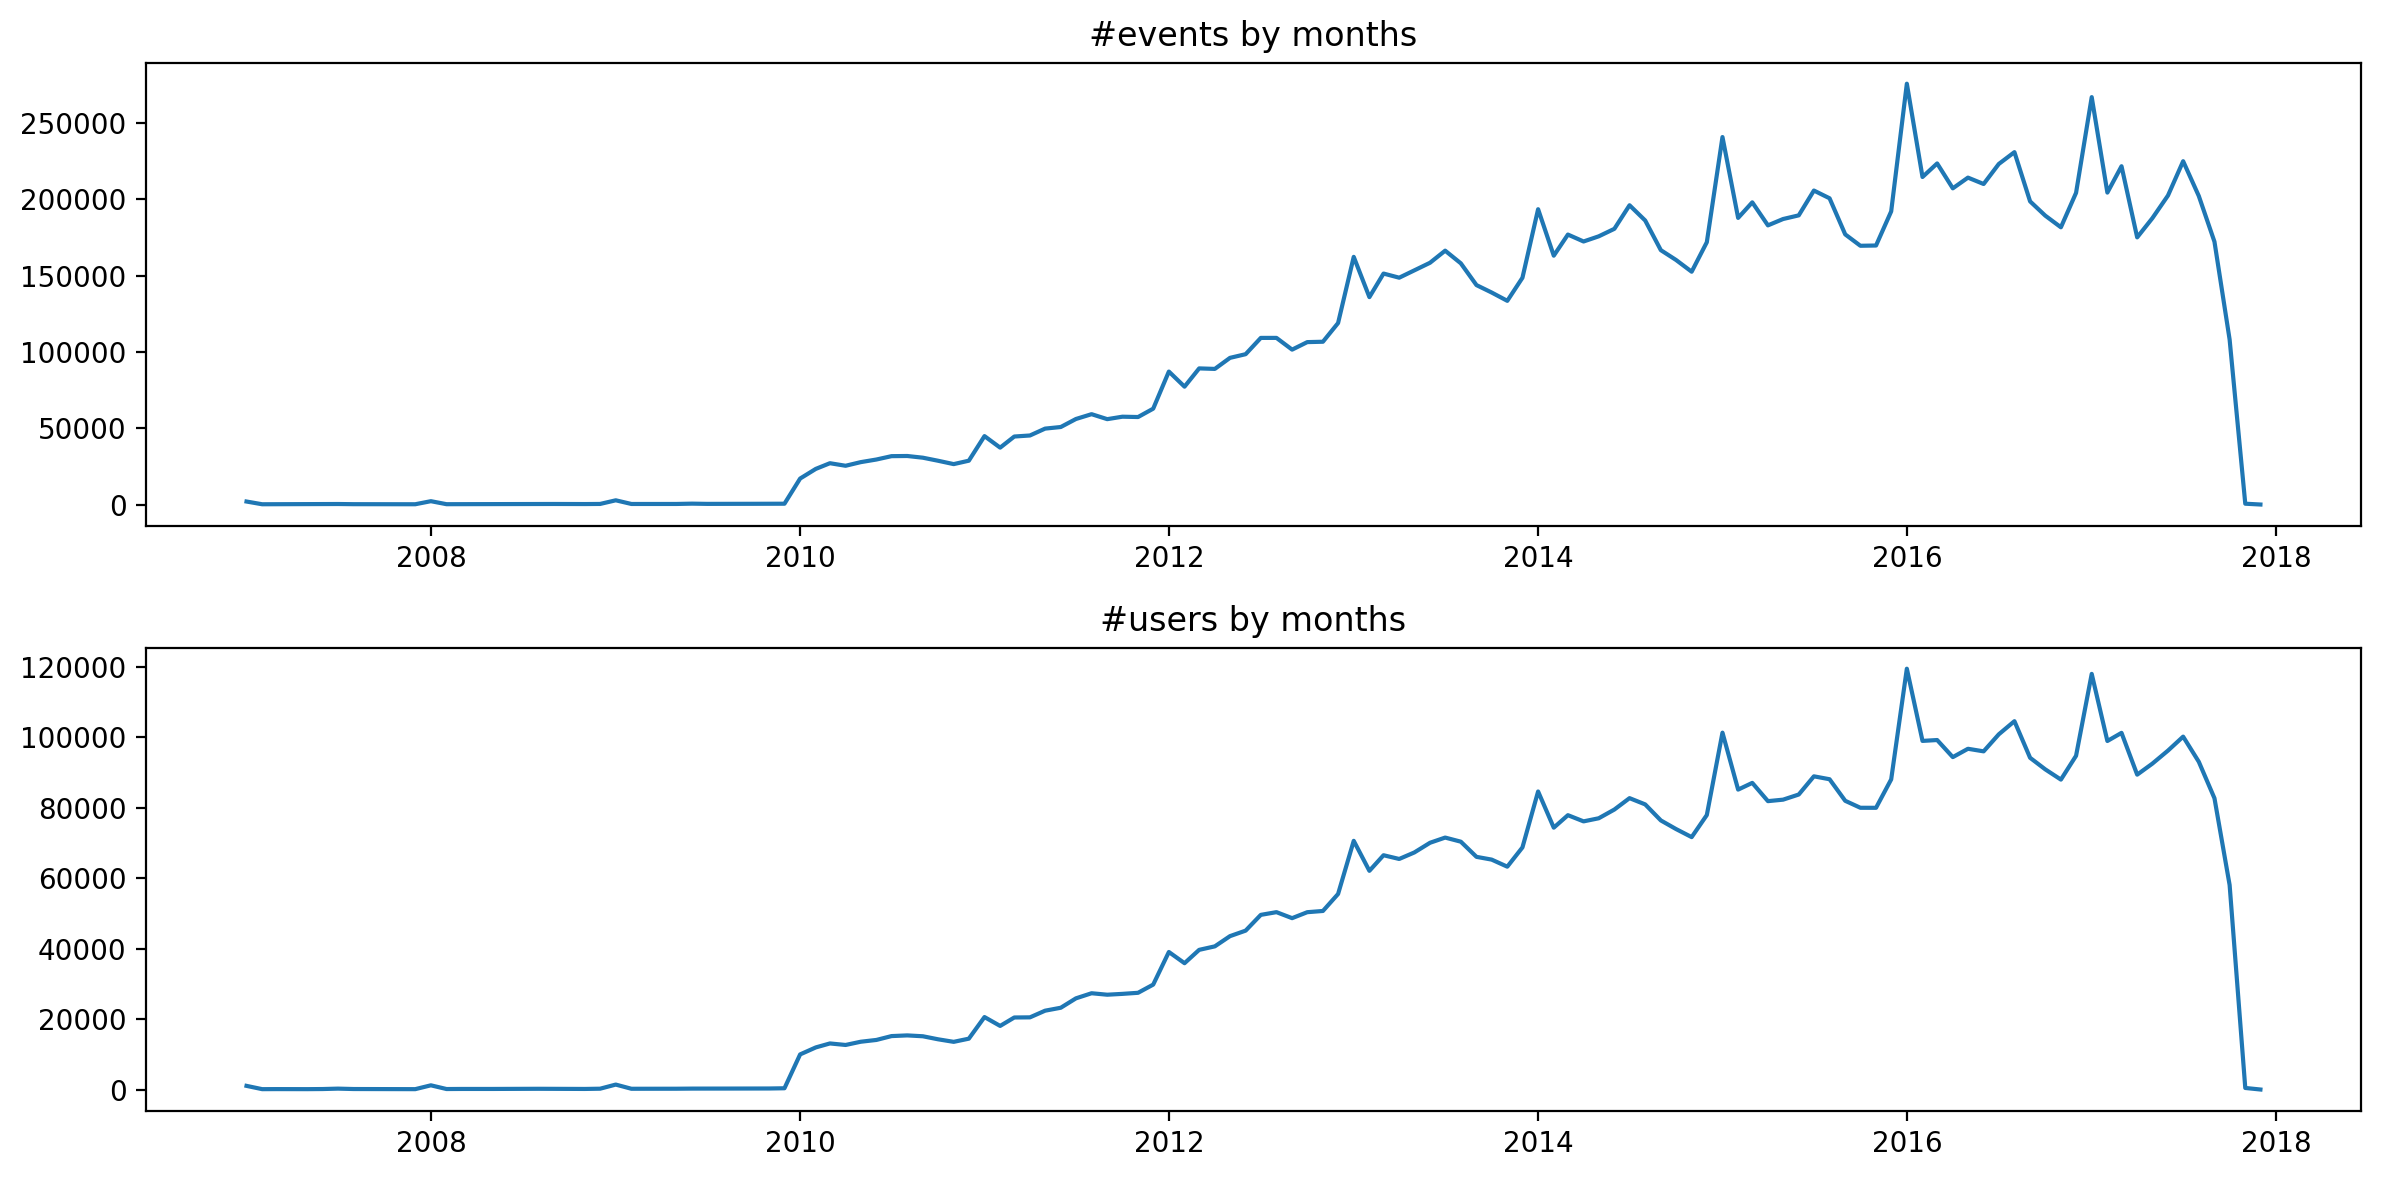

In [17]:
# Распределение взаимодействий и пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

Найдем топ-100 наиболее популярных треков по кол-ву прослушиваний за последние несколько лет.

In [32]:
top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(plays=("started_at", "count"), users=("user_id", "nunique")).reset_index()

# Сортируем по убыванию кол-ва прослушиваний
item_popularity = item_popularity.sort_values('plays', ascending=False)

# Выбираем первые 100 самых популярных айтемов 
top_k_pop_items = item_popularity[:100].reset_index()

Определим наиболее популярные жанры. Для этого пройдем по ранее отобранным топ-трекам и посчитаем,
к каким жанрам они относятся. Наиболее часто встречающиеся жанры будут самыми популярными.

In [ ]:
def get_genres(items, catalog_names):

    """ 
    Извлекает жанры из переданных треков;
    подсчитывает, сколько раз встречается каждый жанр
    """
    cat_genres = catalog_names.query("type == 'genre'")
    
    genres_counter = {}
    
    for k, v in items.iterrows():
        genre_ids = v["genres"] 
        if genre_ids is None or not isinstance(genre_ids, list):
            continue
        for genre_id in genre_ids:
            if genre_id == -1:
                continue
            genre = cat_genres[cat_genres['id'] == genre_id]['name'].values[0]
            # увеличиваем счётчик жанров
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 0

    genres = pd.Series(genres_counter, name="tracks_count")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
        
    return genres

In [ ]:
top_pop_genres = get_genres(top_k_pop_items)
top_pop_genres.sort_values(by="tracks_count", ascending=False).head(10)

Находим треки, которые никто не прослушал.

In [42]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которых нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
not_played_items = items[items['track_id'].isin(not_played_items_ids)]
print(not_played_items[['track_id', 'track_name']].to_string())